In [1]:
# Dependency imports
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# Notebook customizations
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1

### Properties EDA

In [2]:
properties_df = pd.read_csv("./output/engineered_trulia_properties.csv", sep="|", dtype={'zip_code': str}, encoding="latin1")
properties_df

,address,area_sqft,basement_type,built_year,city,exterior_type,heating_type,lot_size,no_of_baths,no_of_bedrooms,no_of_parking_spaces,no_of_stories,parking_type,property_type,property_url,state,tax_amount,tax_year,zip_code
0,145 Como Park Blvd,600.0,NaN,1950.0,Cheektowaga,NaN,NaN,4890.0,1.0,2.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ny/cheektowaga/145-como-park-blvd-cheektowaga-ny-14227--2158517535,NY,2773.65,2017.0,14227
1,192 Peekamoose Rd,NaN,NaN,NaN,Sundown,NaN,NaN,91476.0,NaN,NaN,NaN,NaN,NaN,Income/Investment,https://www.trulia.com/p/ny/sundown/192-peekamoose-rd-sundown-ny-12740--2011727501,NY,701.24,2017.0,12740
2,130 Winter Park Rd,1984.0,NaN,1978.0,Southington,NaN,NaN,22651.2,1.5,3.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/130-winter-park-rd-southington-ct-06489--2005300886,CT,6073.00,2018.0,06489
3,120 Winter Park Rd,1184.0,NaN,1978.0,Southington,NaN,NaN,21780.0,1.0,4.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/120-winter-park-rd-southington-ct-06489--2005300291,CT,5032.00,2018.0,06489
4,11 Winter Park Rd,1452.0,NaN,1966.0,Southington,NaN,NaN,24829.2,2.5,3.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/11-winter-park-rd-southington-ct-06489--2005300224,CT,4959.00,2018.0,06489
5,48 Winter Wood Rd,1884.0,NaN,1984.0,Southington,NaN,NaN,43560.0,2.5,3.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/48-winter-wood-rd-southington-ct-06489--2005308335,CT,6942.00,2018.0,06489
6,18 Winter Wood Rd,3220.0,NaN,1979.0,Southington,NaN,NaN,43560.0,2.5,NaN,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/18-winter-wood-rd-southington-ct-06489--2005303122,CT,8722.00,2018.0,06489
7,192 Water St,1656.0,NaN,1900.0,Southington,NaN,NaN,12632.4,2.0,4.0,NaN,NaN,NaN,Multi-Family,https://www.trulia.com/p/ct/southington/192-water-st-southington-ct-06489--2005303183,CT,4207.00,2018.0,06489
8,172 Water St,1500.0,NaN,1900.0,Southington,NaN,NaN,18730.8,2.0,3.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/172-water-st-southington-ct-06489--2005302545,CT,3794.00,2018.0,06489
9,38 Winter Wood Rd,2120.0,NaN,1984.0,Southington,NaN,NaN,54014.4,2.5,3.0,NaN,NaN,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/38-winter-wood-rd-southington-ct-06489--2005307093,CT,7195.00,2018.0,06489


In [3]:
# Dropping columns that do not have any value for now
properties_df.drop(axis=0, inplace=True, columns=['basement_type', 'exterior_type', 'heating_type', 'no_of_parking_spaces', 'no_of_stories', 'parking_type'])
properties_df

,address,area_sqft,built_year,city,lot_size,no_of_baths,no_of_bedrooms,property_type,property_url,state,tax_amount,tax_year,zip_code
0,145 Como Park Blvd,600.0,1950.0,Cheektowaga,4890.0,1.0,2.0,Single-Family Home,https://www.trulia.com/p/ny/cheektowaga/145-como-park-blvd-cheektowaga-ny-14227--2158517535,NY,2773.65,2017.0,14227
1,192 Peekamoose Rd,NaN,NaN,Sundown,91476.0,NaN,NaN,Income/Investment,https://www.trulia.com/p/ny/sundown/192-peekamoose-rd-sundown-ny-12740--2011727501,NY,701.24,2017.0,12740
2,130 Winter Park Rd,1984.0,1978.0,Southington,22651.2,1.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/130-winter-park-rd-southington-ct-06489--2005300886,CT,6073.00,2018.0,06489
3,120 Winter Park Rd,1184.0,1978.0,Southington,21780.0,1.0,4.0,Single-Family Home,https://www.trulia.com/p/ct/southington/120-winter-park-rd-southington-ct-06489--2005300291,CT,5032.00,2018.0,06489
4,11 Winter Park Rd,1452.0,1966.0,Southington,24829.2,2.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/11-winter-park-rd-southington-ct-06489--2005300224,CT,4959.00,2018.0,06489
5,48 Winter Wood Rd,1884.0,1984.0,Southington,43560.0,2.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/48-winter-wood-rd-southington-ct-06489--2005308335,CT,6942.00,2018.0,06489
6,18 Winter Wood Rd,3220.0,1979.0,Southington,43560.0,2.5,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/18-winter-wood-rd-southington-ct-06489--2005303122,CT,8722.00,2018.0,06489
7,192 Water St,1656.0,1900.0,Southington,12632.4,2.0,4.0,Multi-Family,https://www.trulia.com/p/ct/southington/192-water-st-southington-ct-06489--2005303183,CT,4207.00,2018.0,06489
8,172 Water St,1500.0,1900.0,Southington,18730.8,2.0,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/172-water-st-southington-ct-06489--2005302545,CT,3794.00,2018.0,06489
9,38 Winter Wood Rd,2120.0,1984.0,Southington,54014.4,2.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/38-winter-wood-rd-southington-ct-06489--2005307093,CT,7195.00,2018.0,06489


In [4]:
# Convert the columns to their proper data types
properties_df['built_year'] = properties_df['built_year'].fillna(value=0)
properties_df['tax_year'] = properties_df['tax_year'].fillna(value=0)
properties_df = properties_df.astype(dtype={'area_sqft': np.float, 'built_year': np.int, 'lot_size': np.float, \
                                            'no_of_baths': np.float, 'no_of_bedrooms': np.float, \
                                            'tax_amount': np.float, 'tax_year': np.int})
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23378 entries, 0 to 23377
Data columns (total 13 columns):
address           23375 non-null object
area_sqft         21912 non-null float64
built_year        23378 non-null int64
city              23373 non-null object
lot_size          22286 non-null float64
no_of_baths       21202 non-null float64
no_of_bedrooms    21200 non-null float64
property_type     23375 non-null object
property_url      23378 non-null object
state             23373 non-null object
tax_amount        23282 non-null float64
tax_year          23378 non-null int64
zip_code          23373 non-null object
dtypes: float64(5), int64(2), object(6)
memory usage: 2.3+ MB


In [5]:
properties_df

,address,area_sqft,built_year,city,lot_size,no_of_baths,no_of_bedrooms,property_type,property_url,state,tax_amount,tax_year,zip_code
0,145 Como Park Blvd,600.0,1950,Cheektowaga,4890.0,1.0,2.0,Single-Family Home,https://www.trulia.com/p/ny/cheektowaga/145-como-park-blvd-cheektowaga-ny-14227--2158517535,NY,2773.65,2017,14227
1,192 Peekamoose Rd,NaN,0,Sundown,91476.0,NaN,NaN,Income/Investment,https://www.trulia.com/p/ny/sundown/192-peekamoose-rd-sundown-ny-12740--2011727501,NY,701.24,2017,12740
2,130 Winter Park Rd,1984.0,1978,Southington,22651.2,1.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/130-winter-park-rd-southington-ct-06489--2005300886,CT,6073.00,2018,06489
3,120 Winter Park Rd,1184.0,1978,Southington,21780.0,1.0,4.0,Single-Family Home,https://www.trulia.com/p/ct/southington/120-winter-park-rd-southington-ct-06489--2005300291,CT,5032.00,2018,06489
4,11 Winter Park Rd,1452.0,1966,Southington,24829.2,2.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/11-winter-park-rd-southington-ct-06489--2005300224,CT,4959.00,2018,06489
5,48 Winter Wood Rd,1884.0,1984,Southington,43560.0,2.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/48-winter-wood-rd-southington-ct-06489--2005308335,CT,6942.00,2018,06489
6,18 Winter Wood Rd,3220.0,1979,Southington,43560.0,2.5,NaN,Single-Family Home,https://www.trulia.com/p/ct/southington/18-winter-wood-rd-southington-ct-06489--2005303122,CT,8722.00,2018,06489
7,192 Water St,1656.0,1900,Southington,12632.4,2.0,4.0,Multi-Family,https://www.trulia.com/p/ct/southington/192-water-st-southington-ct-06489--2005303183,CT,4207.00,2018,06489
8,172 Water St,1500.0,1900,Southington,18730.8,2.0,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/172-water-st-southington-ct-06489--2005302545,CT,3794.00,2018,06489
9,38 Winter Wood Rd,2120.0,1984,Southington,54014.4,2.5,3.0,Single-Family Home,https://www.trulia.com/p/ct/southington/38-winter-wood-rd-southington-ct-06489--2005307093,CT,7195.00,2018,06489


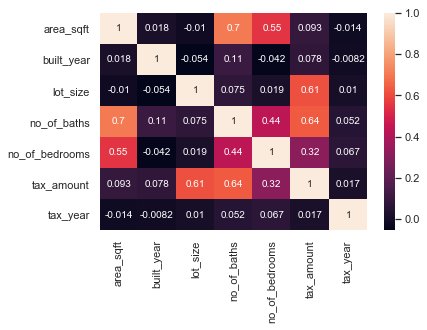

In [6]:
sns.heatmap(data=properties_df.corr(), annot=True)

### Correlated Features from Properties

* area_sqft vs. no_of_baths (0.7)
* no_of_baths vs. tax_amount (0.64)
* lot_size vs. tax_amount (0.61)
* area_sqft vs. no_of_bedrooms (0.55)
* no_of_bedrooms vs no_of_baths (0.44)

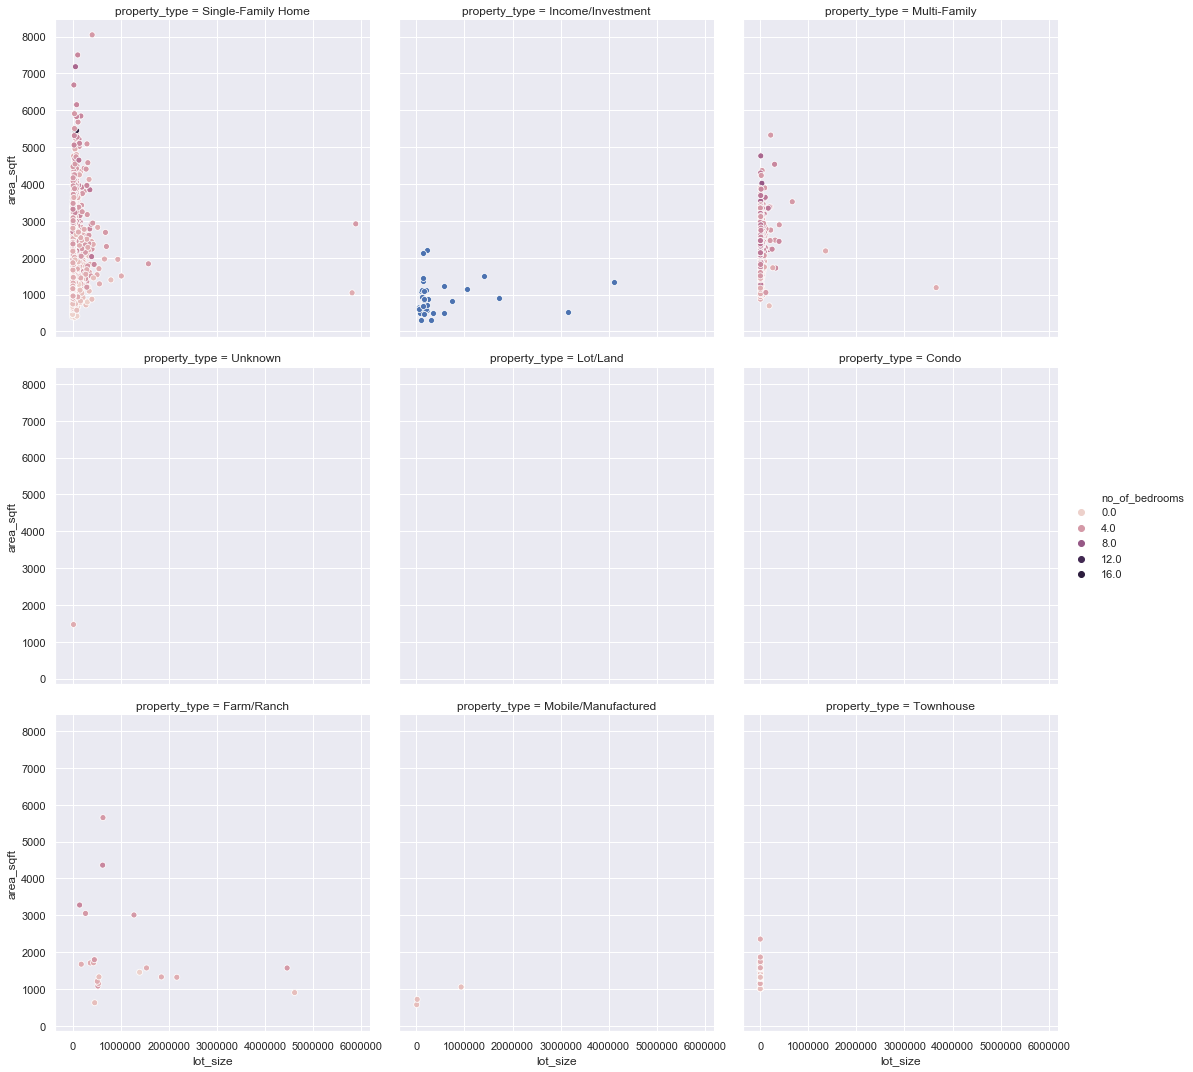

In [8]:
sns.relplot(data=properties_df, x='lot_size', y='area_sqft', hue="no_of_bedrooms", col="property_type", col_wrap=3)